In [1]:
import numpy as np
import os
import cv2
from skimage import color
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

2024-04-23 08:01:10.035254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 08:01:10.035346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 08:01:10.164357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Step 1: Load and preprocess the dataset
data_dir = '/kaggle/input/riceleaf/rice-leaf-desease'
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

images = []
labels = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize image to match CNN input size
        
        # Preprocess image: Remove noise using Gaussian blur
        img = cv2.GaussianBlur(img, (5, 5), 0)
        
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

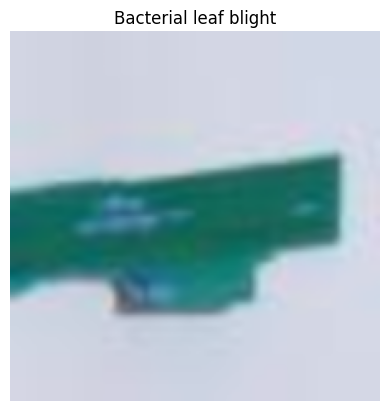

In [6]:
import matplotlib.pyplot as plt

# Choose an index to display an image
index = 0

# Display the preprocessed image
plt.imshow(images[index])
plt.title(class_names[labels[index]])
plt.axis('off')
plt.show()


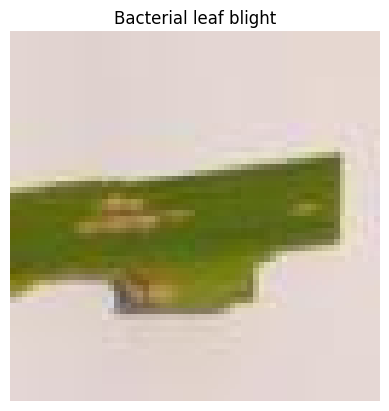

In [7]:
import matplotlib.pyplot as plt

# Choose an index to display an image
index = 0

# Display the original input image
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(data_dir,
                                                class_names[labels[index]], 
os.listdir(os.path.join(data_dir, class_names[labels[index]]))[0])), 
                    cv2.COLOR_BGR2RGB))
plt.title(class_names[labels[index]])
plt.axis('off')
plt.show()


In [3]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                            test_size=0.2, random_state=42)
# Step 2: Preprocess images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [4]:
from skimage.feature import hog
# Extract HOG features for each image
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    hog_features = hog(gray_image, block_norm='L2-Hys', 
                       pixels_per_cell=(16, 16))
    return hog_features

hog_features_train = np.array([extract_hog_features(img) for img in X_train])
hog_features_test = np.array([extract_hog_features(img) for img in X_test])


In [5]:
# Reshape the features for CNN input
X_train_features = hog_features_train.reshape(hog_features_train.shape[0], 
                                              hog_features_train.shape[1], 1)
X_test_features = hog_features_test.reshape(hog_features_test.shape[0], 
                                            hog_features_test.shape[1], 1)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the ResNet50 model with pre-trained weights
resnet_base = ResNet50(weights='imagenet', include_top=False, 
                       input_shape=(224, 224, 3))

# Unfreeze the top convolutional blocks
for layer in resnet_base.layers:
    layer.trainable = False

# Add your own classification layers
x = Flatten()(resnet_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Assuming num_classes is the number of classes in your dataset

# Create the final model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_resnet = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                           epochs=30, batch_size=32)

# Evaluate the model
loss_resnet, accuracy_resnet = model.evaluate(X_test, y_test)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision_resnet = precision_score(y_test, y_pred_labels, average='weighted')
recall_resnet = recall_score(y_test, y_pred_labels, average='weighted')
f1_resnet = f1_score(y_test, y_pred_labels, average='weighted')

print("Test Loss:", loss_resnet)
print("Test Accuracy:", accuracy_resnet)
print("Precision:", precision_resnet)
print("Recall:", recall_resnet)
print("F1 Score:", f1_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,279,108 (187.98 MB)

 Trainable params: 25,691,396 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
  3/400 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.1962 - loss: 2.7439 

I0000 00:00:1713857924.951923      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.3518 - loss: 1.5342 - val_accuracy: 0.4684 - val_loss: 1.1145
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5183 - loss: 1.0721 - val_accuracy: 0.6216 - val_loss: 0.8911
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5686 - loss: 0.9980 - val_accuracy: 0.5875 - val_loss: 0.9225
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.6313 - loss: 0.8640 - val_accuracy: 0.6619 - val_loss: 0.7806
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6291 - loss: 0.8360 - val_accuracy: 0.7513 - val_loss: 0.7120
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6639 - loss: 0.7917 - val_accuracy: 0.7412 - val_loss: 0.6911
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6782 - loss: 0.7537 - val_accuracy: 0.7384 - val_loss: 0.6576
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.7010 - loss: 0.7041 - val_accurac

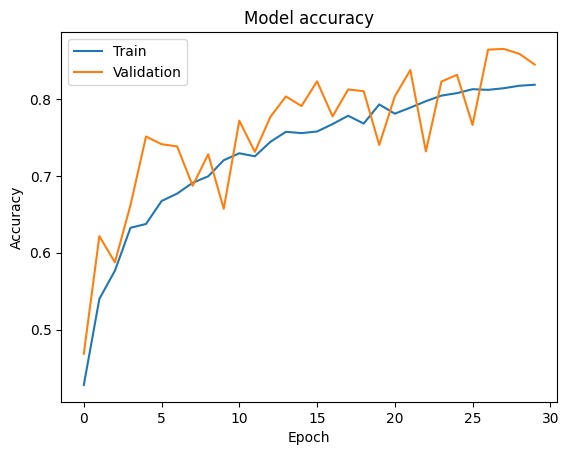

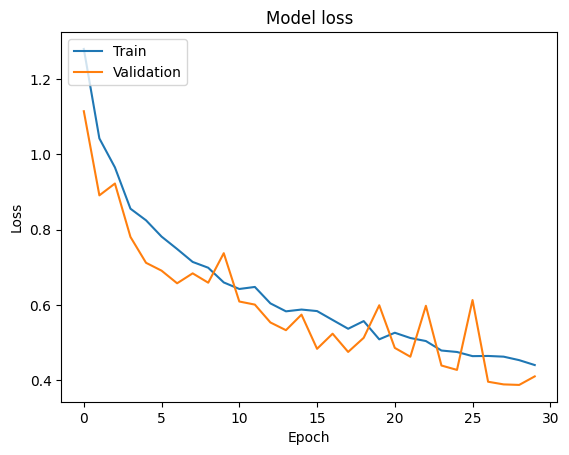

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
# Reshape the features for DecisionTree input
X_train_features = hog_features_train.reshape(hog_features_train.shape[0], -1)
X_test_features = hog_features_test.reshape(hog_features_test.shape[0], -1)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, 
f1_score

# Create a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the classifier
decision_tree.fit(X_train_features, y_train)

# Make predictions on the test data
y_pred = decision_tree.predict(X_test_features)

# Calculate accuracy, precision, recall, and F1 score
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred, average='weighted')
recall_dt = recall_score(y_test, y_pred, average='weighted')
f1_dt = f1_score(y_test, y_pred, average='weighted')

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Precision:", precision_dt)
print("Decision Tree Recall:", recall_dt)
print("Decision Tree F1 Score:", f1_dt)

Decision Tree Accuracy: 0.723125
Decision Tree Precision: 0.7249641734338845
Decision Tree Recall: 0.723125
Decision Tree F1 Score: 0.7237834055717103


In [6]:
# Define a CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', 
                        input_shape=(X_train_features.shape[1], 1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_cnn = model.fit(X_train_features, y_train, 
    validation_data=(X_test_features, y_test), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_features, y_test)

# Make predictions on the test data
y_pred = model.predict(X_test_features)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Test Loss (CNN):", loss)
print("Test Accuracy (CNN):", accuracy)
print("Precision (CNN):", precision)
print("Recall (CNN):", recall)
print("F1 Score (CNN):", f1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
  2/400 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.2734 - loss: 1.4137

I0000 00:00:1713859597.653778      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.6585 - loss: 0.7873 - val_accuracy: 0.8691 - val_loss: 0.3771
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.8828 - loss: 0.3229 - val_accuracy: 0.8666 - val_loss: 0.3161
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9285 - loss: 0.2206 - val_accuracy: 0.9194 - val_loss: 0.2262
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9432 - loss: 0.1689 - val_accuracy: 0.9356 - val_loss: 0.1759
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9578 - loss: 0.1283 - val_accuracy: 0.9425 - val_loss: 0.1613
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.9746 - loss: 0.0903 - val_accuracy: 0.9472 - val_loss: 0.1496
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9824 - loss: 0.0663 - val_accuracy: 0.9159 - val_loss: 0.2318
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.9831 - loss: 0.0610 - val_accurac

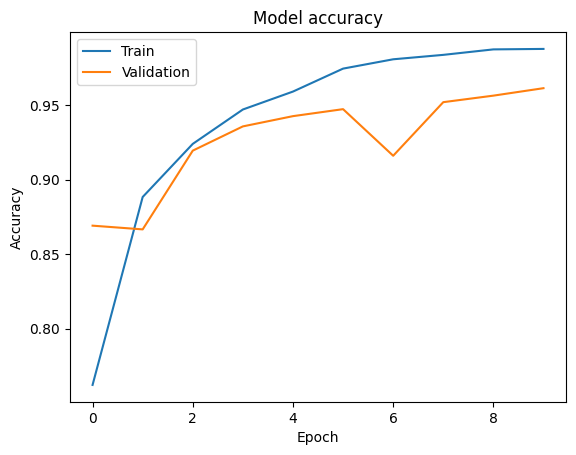

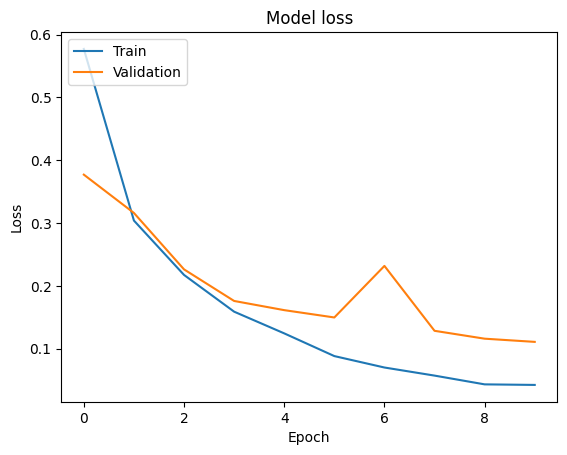

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
model.save('cnn.h5')

In [22]:
from tabulate import tabulate

# Data for ResNet50 and CNN with HOG Features models (replace with actual values)
data = [
["\033[1mDecision Tree\033[0m",  accuracy_dt, precision_dt, recall_dt, f1_dt],
    ["\033[1mResNet50\033[0m", accuracy_resnet, precision_resnet, recall_resnet, 
     f1_resnet],
    ["\033[1mCNN with HOG Features\033[0m", accuracy, precision, recall, f1]
]

# Table headers with bold formatting
headers = ["\033[1mModel\033[0m", "\033[1mTest Accuracy\033[0m", 
"\033[1mPrecision\033[0m", "\033[1mRecall\033[0m", "\033[1mF1 Score\033[0m"]

# Create the table
table = tabulate(data, headers=headers, tablefmt="grid")

# Display the table
print("\033[1mPerformance Metrics Comparison\033[0m")
print(table)


Performance Metrics Comparison
+-----------------------+-----------------+-------------+----------+------------+
| Model                 |   Test Accuracy |   Precision |   Recall |   F1 Score |
+=======================+=================+=============+==========+============+
| Decision Tree         |        0.723125 |    0.724964 | 0.723125 |   0.723783 |
+-----------------------+-----------------+-------------+----------+------------+
| ResNet50              |        0.8075   |    0.861498 | 0.8075   |   0.810051 |
+-----------------------+-----------------+-------------+----------+------------+
| CNN with HOG Features |        0.952812 |    0.954079 | 0.952812 |   0.952561 |
+-----------------------+-----------------+-------------+----------+------------+


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1713161903.475457      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


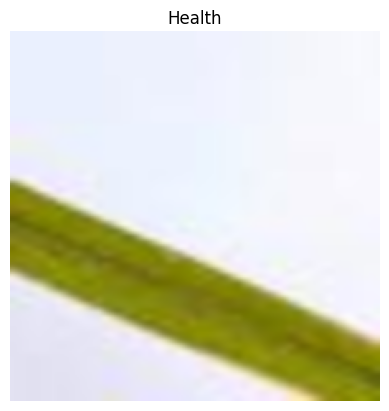

In [5]:
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

# Load the saved model
model = best_model_path = "/kaggle/input/modell/cnn.h5"
model = load_model(best_model_path)

# Path to the image you want to predict
img_path = '/kaggle/input/riceleaf/rice-leaf-desease/Health/Health_original_IMG_20190419_095646.jpg_14b85971-7714-42ee-8922-173ce3b79286.jpg'

# Function to preprocess a single image for prediction
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match CNN input size
    img = cv2.GaussianBlur(img, (5, 5), 0)  # Preprocess image: Remove noise using Gaussian blur
    gray_image = color.rgb2gray(img)
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))  # Extract HOG features
    hog_features = hog_features.reshape(1, -1, 1)  # Reshape features for CNN input
    return hog_features, img

# Preprocess the image
preprocessed_img, original_img = preprocess_image(img_path)

# Make prediction using the model
prediction = model.predict(preprocessed_img)

# Get the predicted class label
predicted_label = np.argmax(prediction)

# Map the predicted label to the corresponding class name
predicted_class_name = class_names[predicted_label]

# Display the image with the predicted class label
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title(predicted_class_name)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


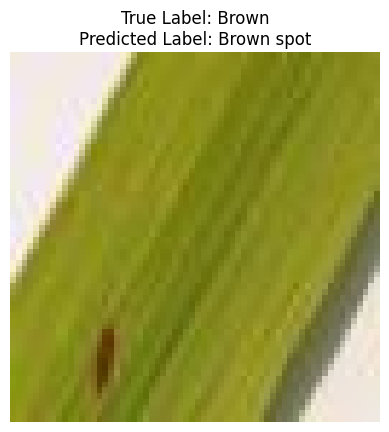

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


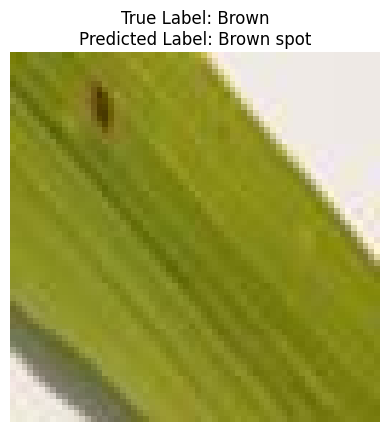

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


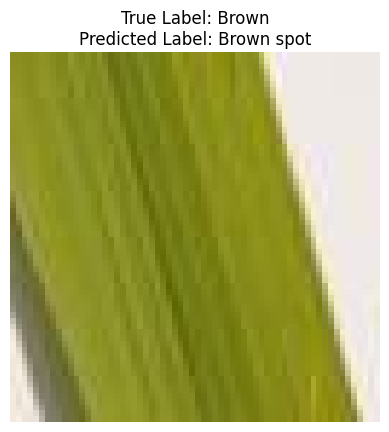

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


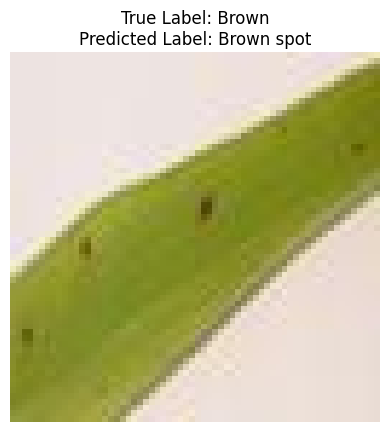

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


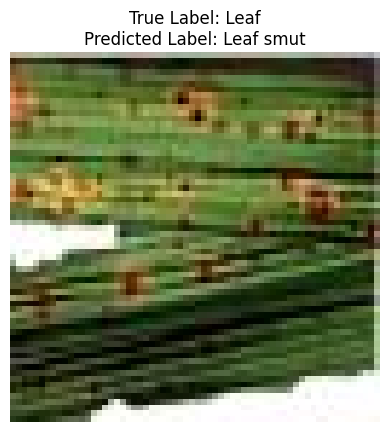

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


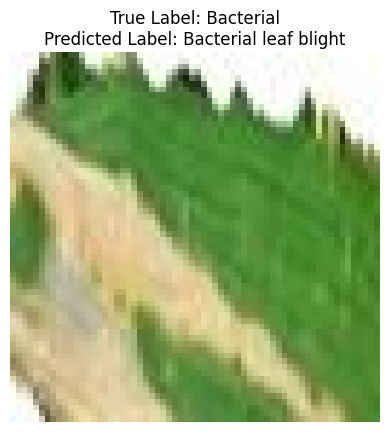

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


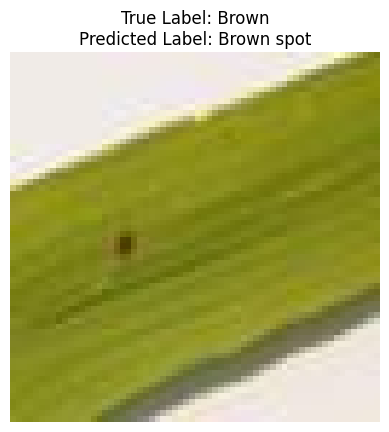

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


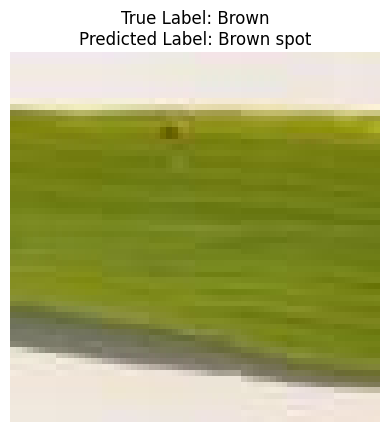

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


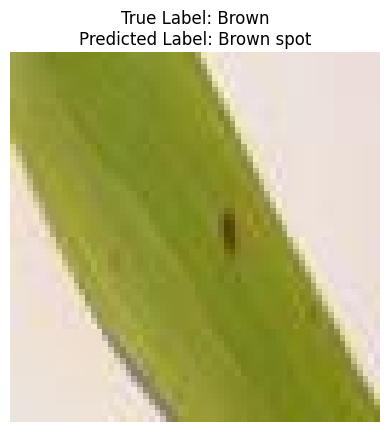

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


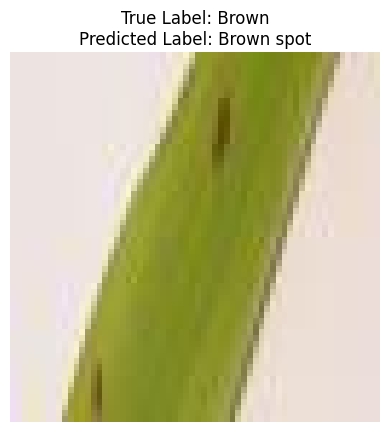

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


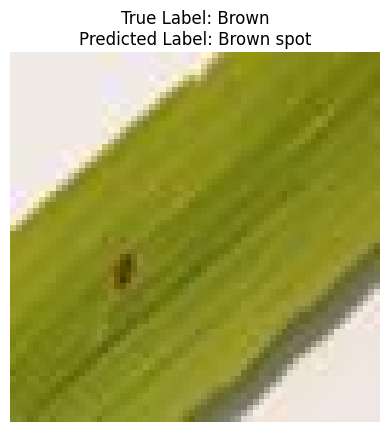

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


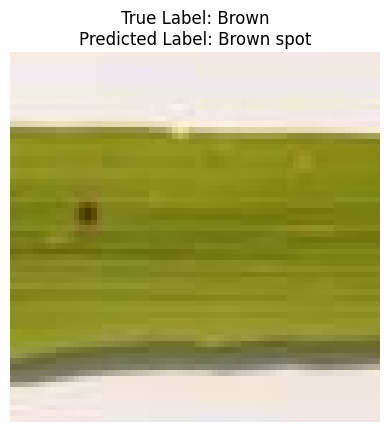

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


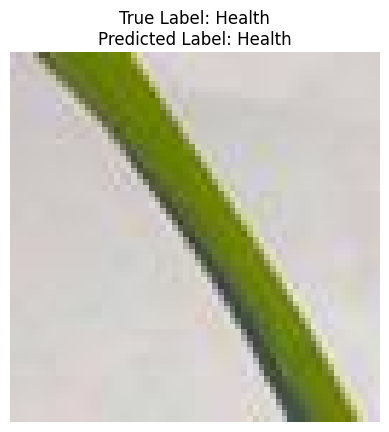

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


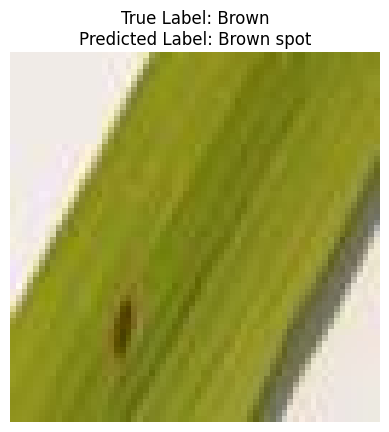

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


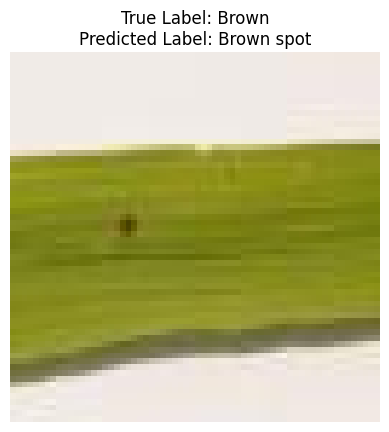

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


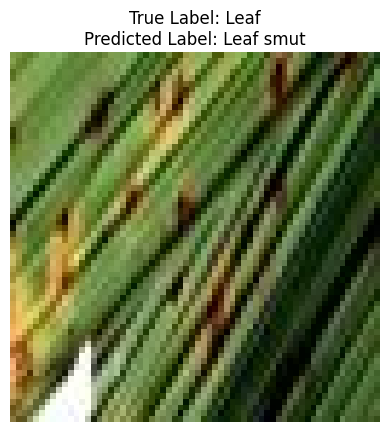

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


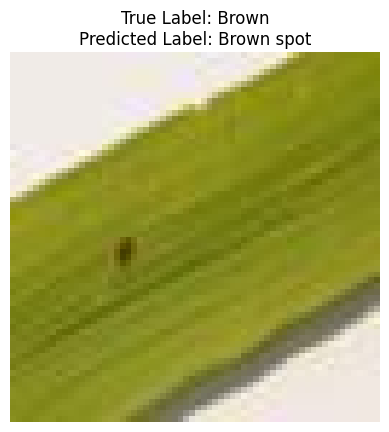

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


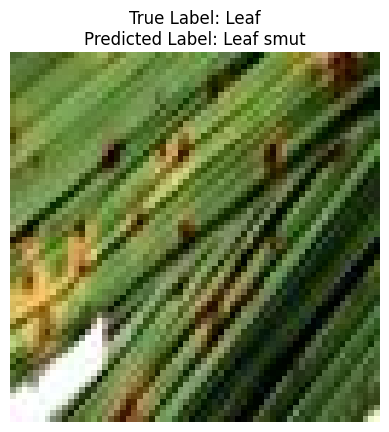

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


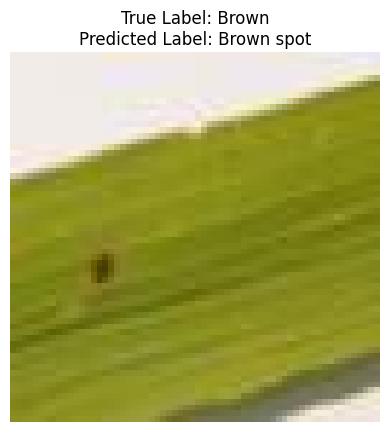

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


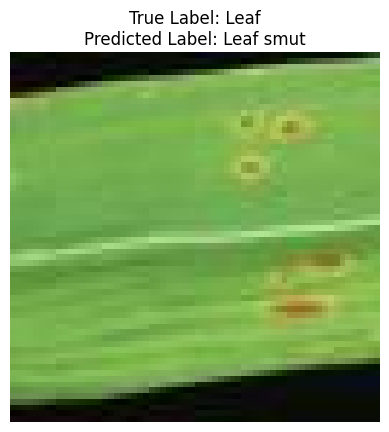

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


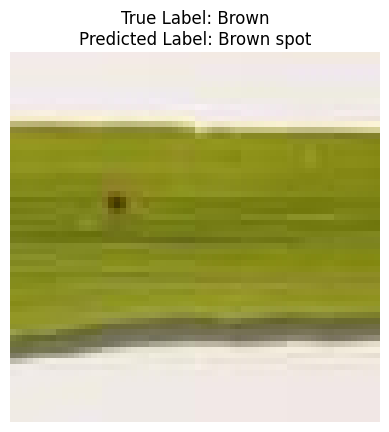

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


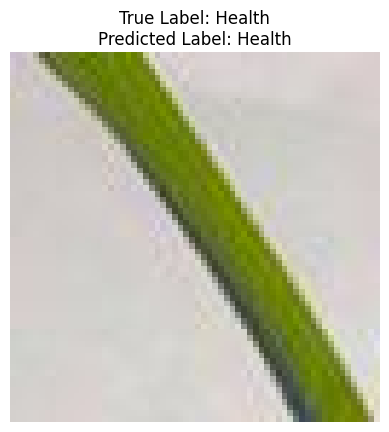

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


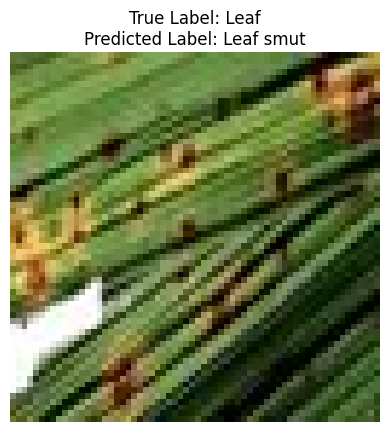

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


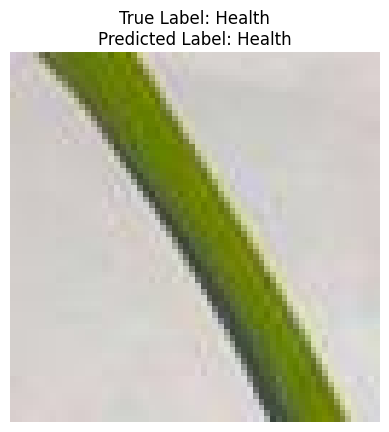

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


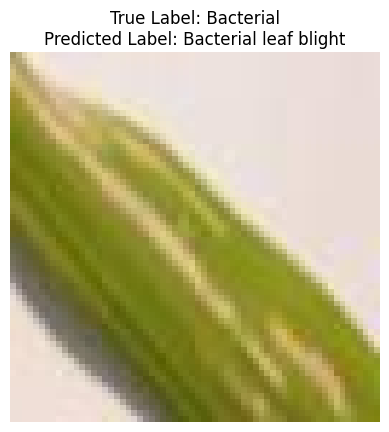

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


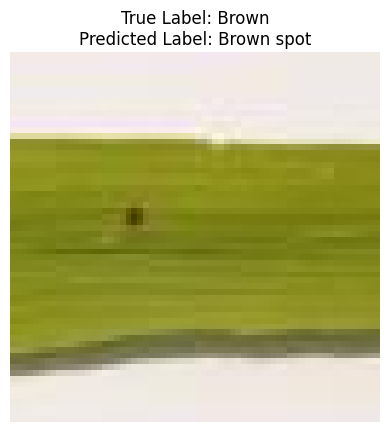

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


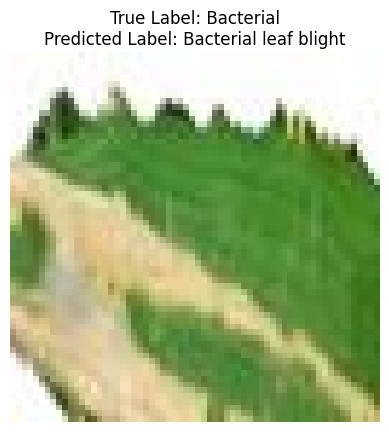

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


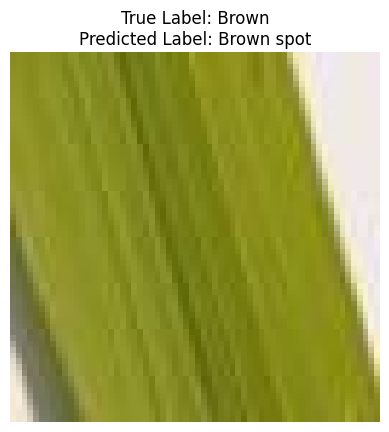

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


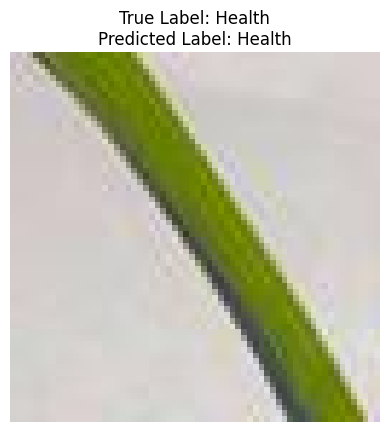

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


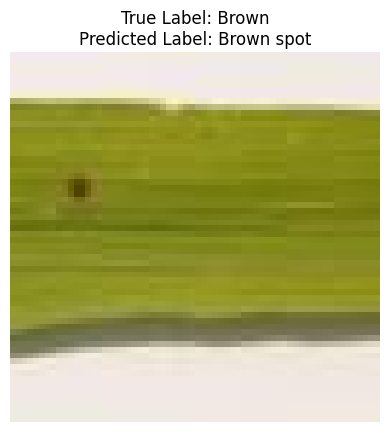

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


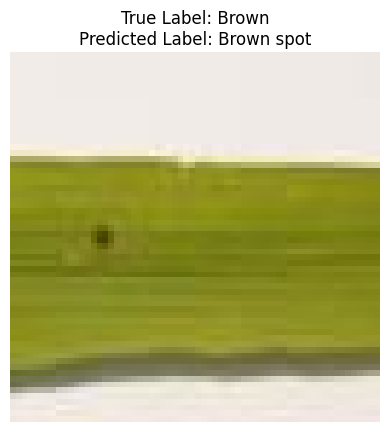

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


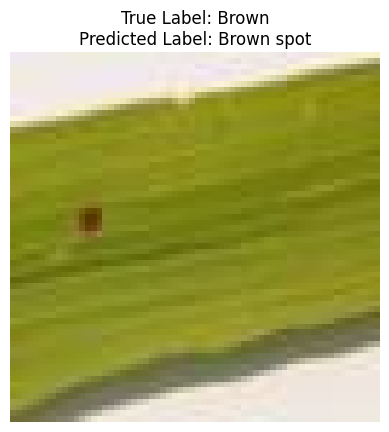

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


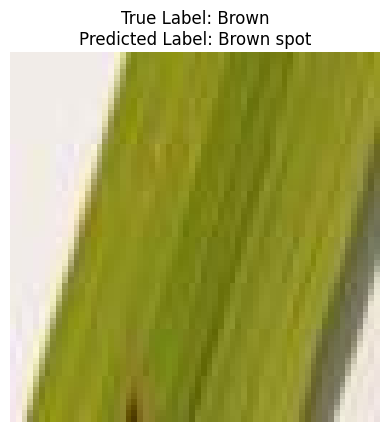

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


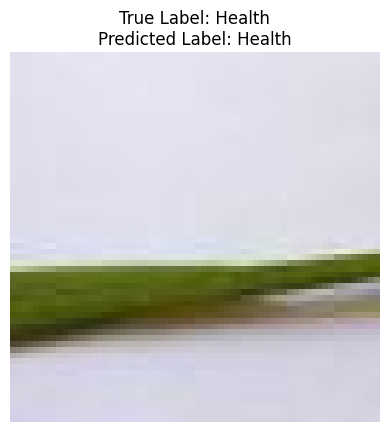

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


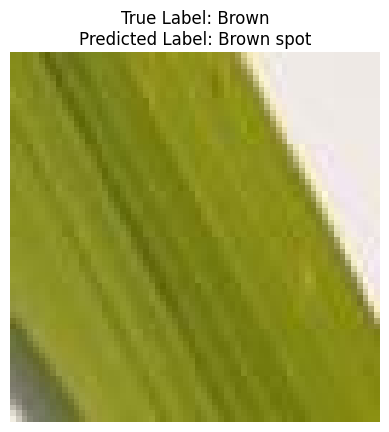

In [25]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('cnn.h5')

# Path to the folder containing images you want to predict
folder_path = '/kaggle/input/test-imagee/TestImageResnet50'

# Function to preprocess an image for prediction
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))  # Resize image to match CNN input size
    img = cv2.GaussianBlur(img, (5, 5), 0)  # Preprocess image: Remove noise using Gaussian blur
    gray_image = color.rgb2gray(img)
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))  # Extract HOG features
    hog_features = hog_features.reshape(1, -1, 1)  # Reshape features for CNN input
    return hog_features

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if
               os.path.isfile(os.path.join(folder_path, f))]

for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)
    
    # Preprocess the image
    preprocessed_img = preprocess_image(img)

    # Make prediction using the model
    prediction = model.predict(preprocessed_img)

    # Get the predicted class label
    predicted_label = np.argmax(prediction)

    # Map the predicted label to the corresponding class name
    predicted_class_name = class_names[predicted_label]

    # Get the true class label from the file name
    true_class_name = img_file.split('_')[0]

    # Display the image with the true and predicted class labels
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'True Label: {true_class_name}\nPredicted Label: 
              {predicted_class_name}')
    plt.axis('off')
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('cnn.h5')

# Path to the folder containing images you want to predict
folder_path = '/kaggle/input/real-time-images/rice images'

# Function to preprocess an image for prediction
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))  # Resize image to match CNN input size
    img = cv2.GaussianBlur(img, (5, 5), 0)  # Preprocess image: Remove noise using Gaussian blur
    gray_image = color.rgb2gray(img)
    hog_features = hog(gray_image, block_norm='L2-Hys',
                       pixels_per_cell=(16, 16))  # Extract HOG features
    hog_features = hog_features.reshape(1, -1, 1)  # Reshape features for CNN input
    return hog_features

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(folder_path) if 
               os.path.isfile(os.path.join(folder_path, f))]

for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)
    
    # Preprocess the image
    preprocessed_img = preprocess_image(img)

    # Make prediction using the model
    prediction = model.predict(preprocessed_img)

    # Get the predicted class label
    predicted_label = np.argmax(prediction)

    # Map the predicted label to the corresponding class name
    predicted_class_name = class_names[predicted_label]

    # Get the true class label from the file name
    true_class_name = img_file.split('_')[0]

    # Display the image with the true and predicted class labels
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'True Label: {true_class_name}\nPredicted Label: {predicted_class_name}')
    plt.axis('off')
    plt.show()

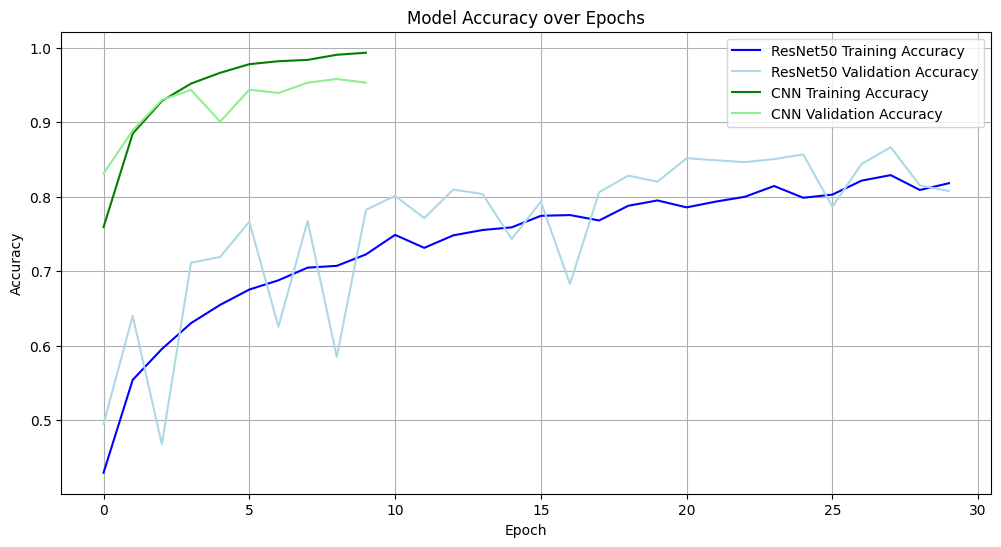

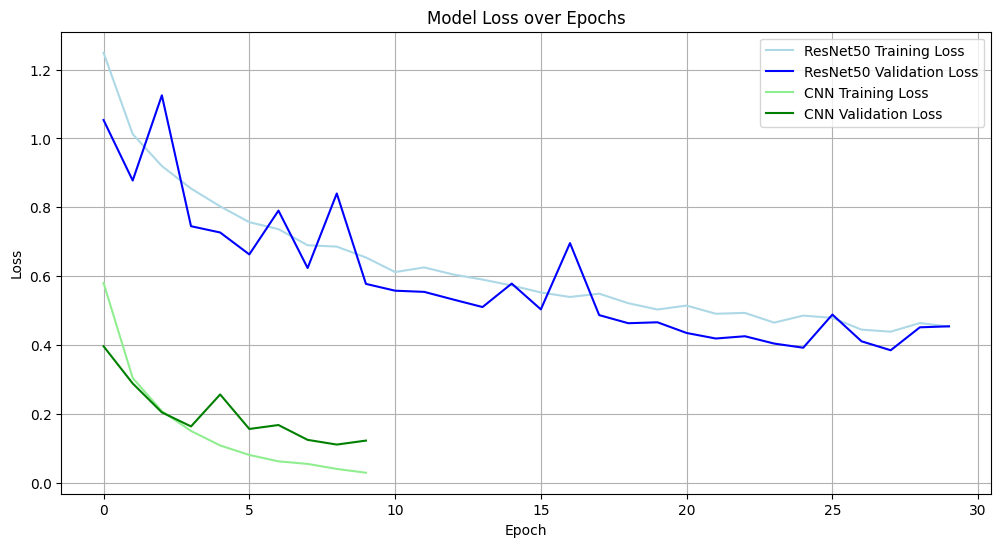

In [32]:
import matplotlib.pyplot as plt

# Plotting the accuracy for each model
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Training Accuracy', color='blue')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Validation Accuracy', color='lightblue')
plt.plot(history.history['accuracy'], label='CNN Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy', color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss for each model
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['loss'], label='ResNet50 Training Loss', color='lightblue')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Validation Loss', color='blue')
plt.plot(history.history['loss'], label='CNN Training Loss', color='lightgreen')
plt.plot(history.history['val_loss'], label='CNN Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()